# Cours M2 EDP et modélisation: simulations numériques de l'équation de la chaleur

In [62]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy.optimize
import math 
from math import sin, pi, log, exp
import os
%matplotlib notebook
from matplotlib.animation import FuncAnimation

Le but est de résoudre par une méthode de différences finies l'équation de transport
$$
\partial_t v(t,x) - \partial_{xx} v(t,x) = 0 \qquad \text{sur $(0,1)$}
$$
avec des conditions de bord périodiques ($v(t,0) = v(t,1)$) et une condition initiale $v(0,x) = v_i(x)$. 


Soit $X \in \mathbb{N}^*$. On note $\displaystyle \Delta x := \frac{1}{X}$ et pour tout $i \in \mathbb{Z}$, on notera $x_i = i \Delta x$ de telle sorte que $x_0 = 0 < x_1 < \cdots < x_X = 1$. 

In [75]:
X = 100 # Nombre de points de discretisation
xx = np.linspace(0, 1, X+1)
dx = 1.0/X
print("les deux valeurs extremales de xx sont ",xx[0]," et ",xx[X])

les deux valeurs extremales de xx sont  0.0  et  1.0


In [64]:
#On definit le pas de temps et le nombre de pas de temps
#dt = 0.01 # 0.01 0.003 pour X=10
dt = 0.0001 # 0.0001 0.00003 pour X=100
#M = 50 # pour X=10
M = 5000 # pour X=100
instant = np.zeros(M)
for ii in range(0,M):
    instant[ii] = ii*dt

# On definit la condition initiale (periodique!)
V0full = np.zeros(X+1)
regul = True # True pour CI reguliere, False sinon
regul = False
for i in range(0,X+1):
    if regul:
        # CI reguliere
        pic = int(X/3)
        picc = int(3*X/5)
        V0full[i] = exp(-50*(xx[i]-xx[pic])**2) + 1.3*exp(-50*(xx[i]-xx[picc])**2) 
        #V0full[i] = sin(2*pi*xx[i]) # mode propre operateur, interessant pour voir EE exploser finalement (X=10)
    else:
        # CI irreguliere
        pic = int(X/2)
        V0full[pic] = 1.
        V0full[pic-1] = 1.
        V0full[pic+1] = 1.
    
print("les deux valeurs extremales de V0full sont ",V0full[0]," et ",V0full[X])

# On prend la restriction en eliminant le dernier ddl (car CL periodiques)
V0 = np.zeros(X) 
for i in range(0,X):
    V0[i] = V0full[i]
print("les deux valeurs extremales de V0 sont ",V0[0]," et ",V0[X-1])

# On evalue la valeur de la condtion CFL $2\Delta t / (\Delta x)^2$ 
# quantité pertinente pour le schéma Euler explicite: elle doit etre inferieure à 1
CFL = 2*dt/(dx*dx)
print("CFL = ", CFL)

les deux valeurs extremales de V0full sont  0.0  et  0.0
les deux valeurs extremales de V0 sont  0.0  et  0.0
CFL =  0.019999999999999997


<IPython.core.display.Javascript object>


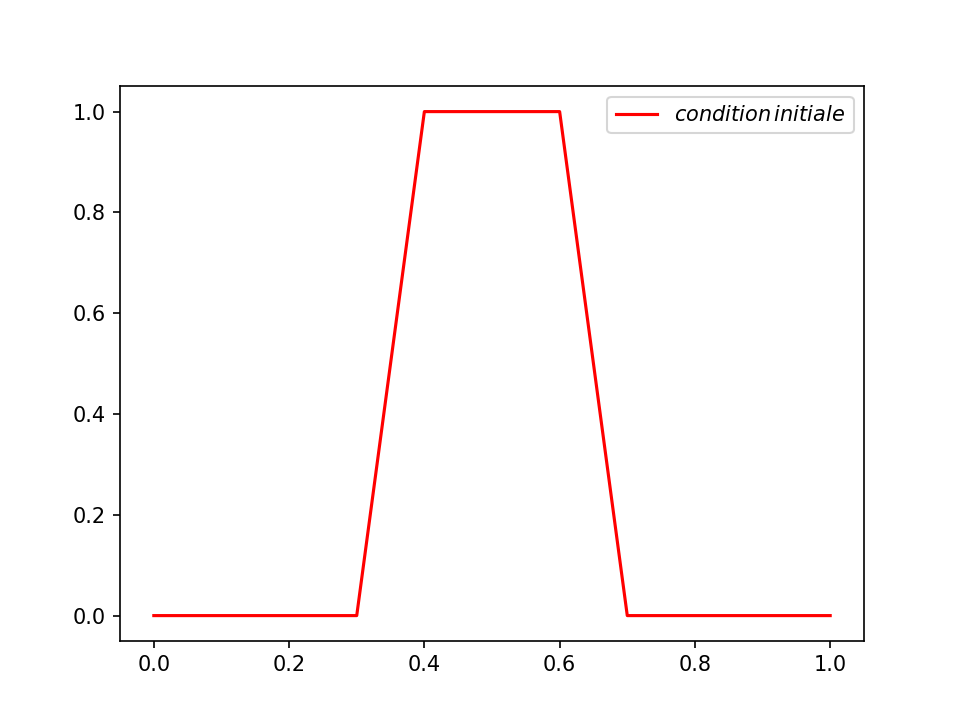

In [65]:
# On visualise la condition initiale
plt.plot(xx,V0full, 'r', label ="$condition \, initiale$")
plt.legend()
plt.show()

In [66]:
plt.close()

In [67]:
# Definition de matrices utiles

# matrice identite
Idd = np.eye(X) 

# matrice sur-diagonale
MatU = np.zeros((X,X))
for i in range(0,X-1):
   MatU[i,i+1] = 1
MatU[X-1,0] = 1 

# matrice sous-diagonale
MatD = np.zeros((X,X))
for i in range(1,X):
   MatD[i,i-1] = 1
MatD[0,X-1] = 1 

# 1- Schéma Euler explicite

In [68]:
# Definition de la matrice de passage

D = np.zeros((X,X))
D = Idd + (dt/(dx*dx))*(MatU-2*Idd+MatD)

In [69]:
# visualisation de la matrice de passage
print(D)

[[0.98 0.01 0.   0.   0.   0.   0.   0.   0.   0.01]
 [0.01 0.98 0.01 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.01 0.98 0.01 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.98 0.01 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.01 0.98 0.01 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.01 0.98 0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.01 0.98 0.01 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.01 0.98 0.01 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.01 0.98 0.01]
 [0.01 0.   0.   0.   0.   0.   0.   0.   0.01 0.98]]


In [70]:
# On realise l'iteration en temps 
     
# On va stocker dans Vtab la solution aux differents pas de temps
Vtab = np.zeros((X,M))
V = V0

for ii in range(0,M):
    Vtab[:,ii] = V
    Vnew = np.dot(D,V) #produit matriciel
    V = Vnew
    
# On complete les tableaux pour avoir le dernier point
Vfull = np.zeros((X+1,M))
for ii in range(0,M):
    for jj in range(0,X):
        Vfull[jj,ii] = Vtab[jj,ii]
    Vfull[X,ii] = Vtab[0,ii]

Le but des lignes de code ci-dessous est d'afficher l'évolution de la fonction $v(t,x)$

<IPython.core.display.Javascript object>


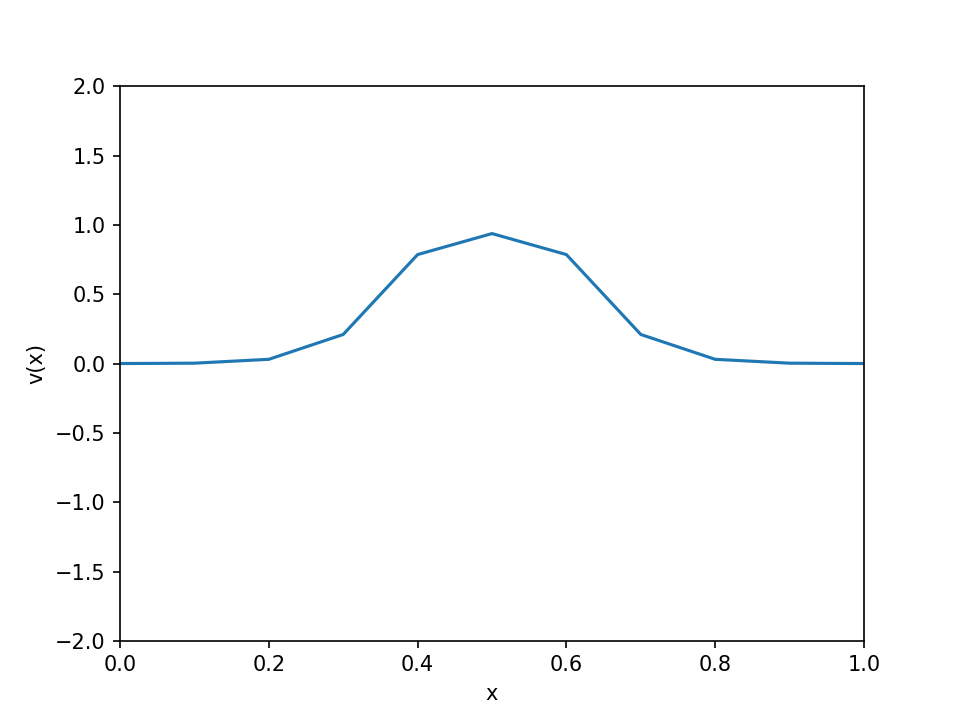

In [71]:
## Le but de cette fonction est d'afficher l'évolution de v(t,x) au cours du temps
fig1, ax1 = plt.subplots(1)
plotV,  = ax1.plot(xx,Vfull[:,0])

def animate(p):
    VV = Vfull[:,p]
    plotV.set_ydata(VV) 
    
def init(): 
    ax1.set_xlim(0, 1)
    ax1.set_ylim( -2., 2.)
    ax1.set_xlabel('x')
    ax1.set_ylabel('v(x)')    
    return plotV,

step = 1
steps = np.arange(1,M,step)
ani1 = FuncAnimation(fig1, animate,steps, init_func = init, interval = 300, blit = True)

In [72]:
plt.close()

In [73]:
# log valeur maximale au cours du temps
logVmax = np.zeros(M)
for ii in range(0,M):
    logVmax[ii] = log(max(Vfull[:,ii]))

<IPython.core.display.Javascript object>


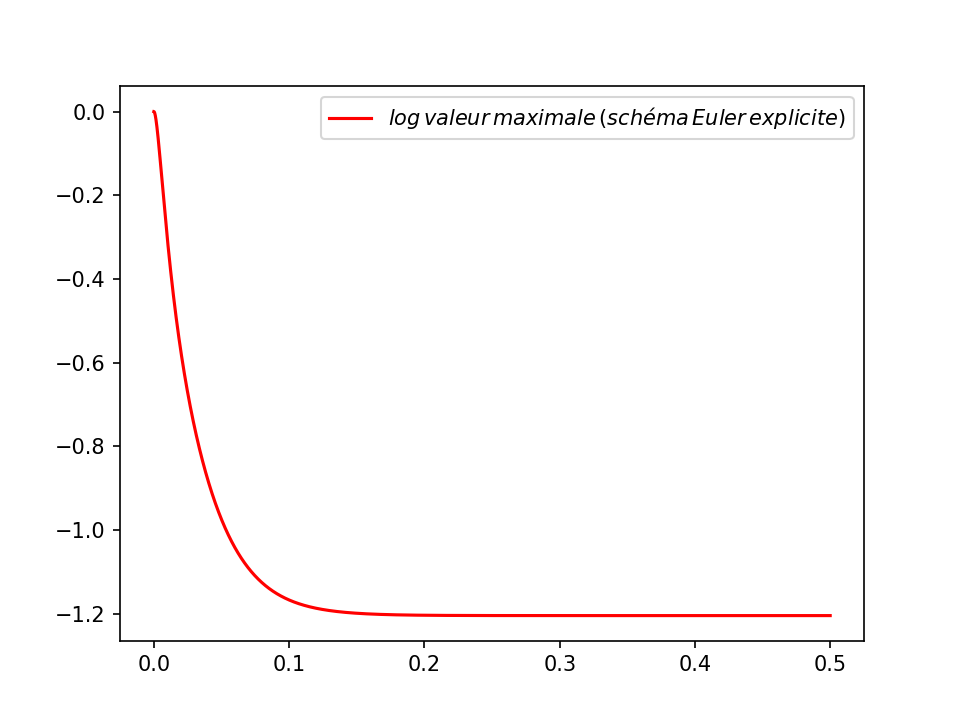

In [74]:
# On visualise le log de la valeur max au cours du temps
plt.plot(instant,logVmax, 'r', label ="$log \, valeur \, maximale \, (schéma \, Euler \, explicite)$")
plt.legend()
plt.show()

In [38]:
plt.close()

# 2- Schéma Euler implicite

In [39]:
# Definition de la matrice de passage à inverser

D = np.zeros((X,X))
D = Idd - (dt/(dx*dx))*(MatU-2*Idd+MatD)

In [40]:
# visualisation de la matrice de passage
print(D)

[[ 3. -1.  0. ...  0.  0. -1.]
 [-1.  3. -1. ...  0.  0.  0.]
 [ 0. -1.  3. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  3. -1.  0.]
 [ 0.  0.  0. ... -1.  3. -1.]
 [-1.  0.  0. ...  0. -1.  3.]]


In [41]:
# On realise l'iteration en temps 
     
# On va stocker dans Vtab la solution aux differents pas de temps
Vtab = np.zeros((X,M))
V = V0

for ii in range(0,M):
    Vtab[:,ii] = V
    Vnew = np.linalg.solve(D,V) #resolution du probleme lineaire
    V = Vnew
    
# On complete les tableaux pour avoir le dernier point
Vfull = np.zeros((X+1,M))
for ii in range(0,M):
    for jj in range(0,X):
        Vfull[jj,ii] = Vtab[jj,ii]
    Vfull[X,ii] = Vtab[0,ii]

Le but des lignes de code ci-dessous est d'afficher l'évolution de la fonction $v(t,x)$

<IPython.core.display.Javascript object>


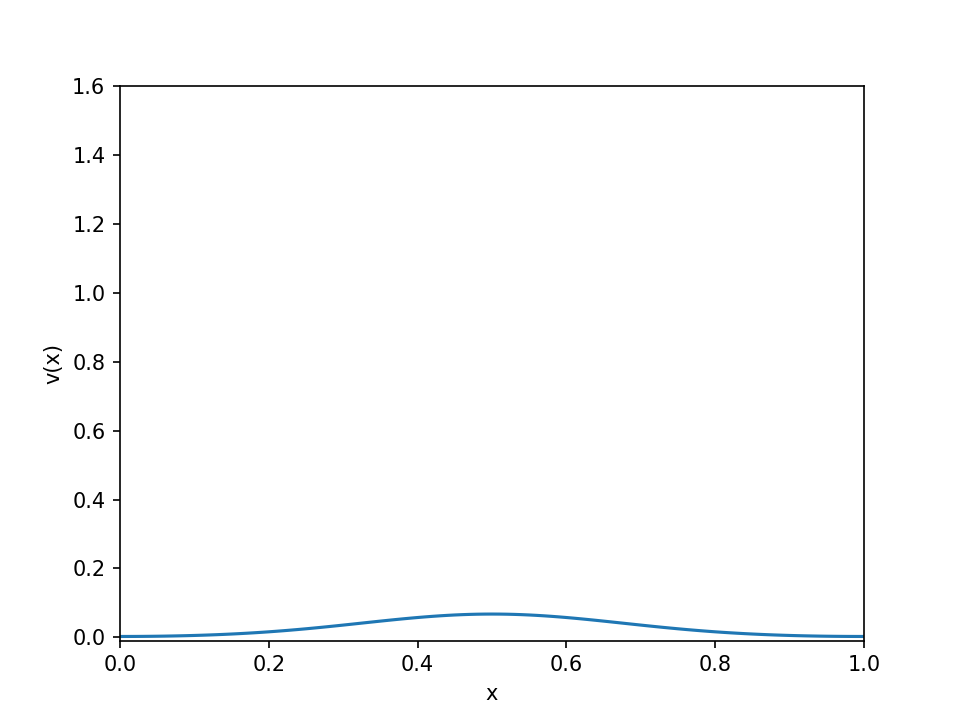

In [47]:
## Le but de cette fonction est d'afficher l'évolution de v(t,x) au cours du temps
fig1, ax1 = plt.subplots(1)
plotV,  = ax1.plot(xx,Vfull[:,0])

def animate(p):
    VV = Vfull[:,p]
    plotV.set_ydata(VV) 
    
def init(): 
    ax1.set_xlim(0, 1)
    ax1.set_ylim( -0.01, 1.6)
    ax1.set_xlabel('x')
    ax1.set_ylabel('v(x)')    
    return plotV,

step = 1
steps = np.arange(1,M,step)
ani1 = FuncAnimation(fig1, animate,steps, init_func = init, interval = 300, blit = True)

In [48]:
plt.close()

In [49]:
# log valeur maximale au cours du temps
logVmax = np.zeros(M)
for ii in range(0,M):
    logVmax[ii] = log(max(Vfull[:,ii]))

<IPython.core.display.Javascript object>


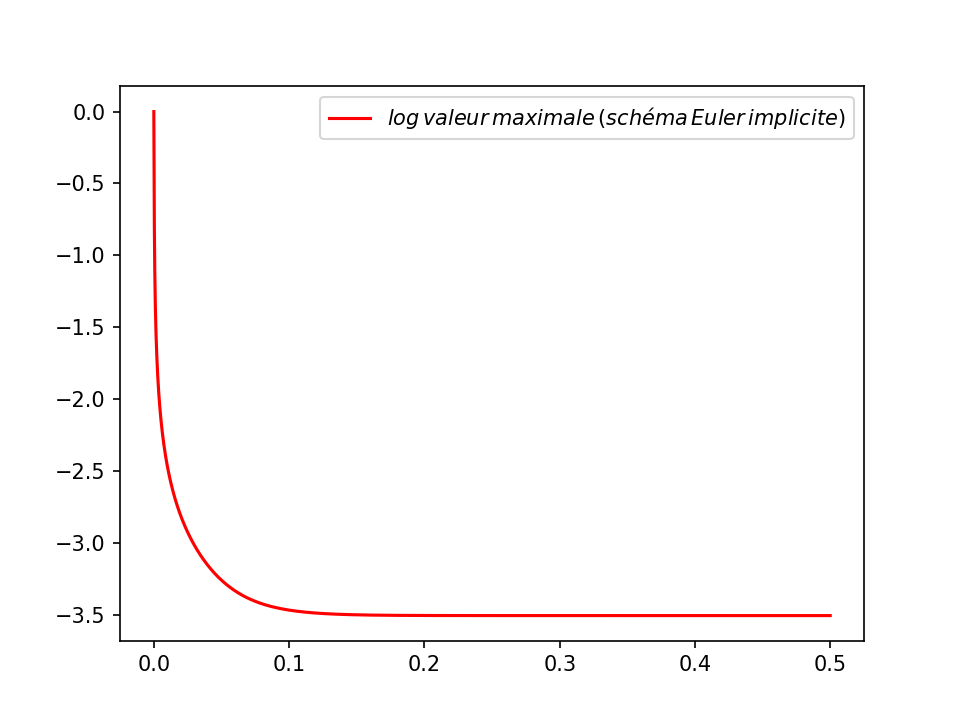

In [50]:
# On visualise le log de la valeur max au cours du temps
plt.plot(instant,logVmax, 'r', label ="$log \, valeur \, maximale \, (schéma \, Euler \, implicite)$")
plt.legend()
plt.show()

In [46]:
plt.close()